# **Data Collecting** 

## Library

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
import joblib

import warnings
warnings.filterwarnings('ignore') #supaya nggak semak

## Load

In [48]:
df = pd.read_csv("dataset/water_quality_potability_v2.csv")
df = df[['ph', 'Solids', 'Turbidity', 'Potability']]
df["Solids"] = (df["Solids"] / 62000) * 1000

display(df[df['Solids'] > 600])
df

,ph,Solids,Turbidity,Potability
16,3.722500,612.293032,3.662838,0
136,5.323816,606.866979,2.880722,0
170,6.106760,635.972707,3.924967,0
308,7.294364,670.483097,3.336582,0
384,6.800119,631.345215,3.854940,1
...,...,...,...,...
13226,7.870853,834.384202,4.221614,1
13236,4.767472,774.320454,3.893378,1
13250,7.371914,678.377104,4.338957,1
13256,7.607224,632.013657,3.525027,1


,ph,Solids,Turbidity,Potability
0,7.160466,365.109446,3.991681,1
1,7.187738,342.952066,3.957064,0
2,5.400302,278.493442,4.824786,0
3,7.078913,347.406221,3.909317,0
4,7.052283,349.346270,3.989340,0
...,...,...,...,...
13271,4.668102,767.435348,4.435821,1
13272,7.808856,279.512938,2.798243,1
13273,9.419510,534.767391,3.298875,1
13274,5.126763,193.288216,4.708658,1


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13276 entries, 0 to 13275
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ph          12785 non-null  float64
 1   Solids      13276 non-null  float64
 2   Turbidity   13276 non-null  float64
 3   Potability  13276 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 415.0 KB


In [50]:
df.describe()

,ph,Solids,Turbidity,Potability
count,12785.000000,13276.000000,13276.000000,13276.000000
mean,7.089108,354.711474,3.971311,0.472883
std,0.971631,88.926568,0.492853,0.499283
min,0.000000,5.176494,1.450000,0.000000
25%,6.992204,341.607842,3.918624,0.000000
50%,7.092450,353.993831,3.973042,0.000000
75%,7.183646,365.391233,4.028042,1.000000
max,14.000000,987.535420,6.739000,1.000000


In [51]:
df_sensor = pd.read_csv('dataset/dataset_sensor.csv')
print(df_sensor.head())
print('\n')
print(df_sensor.info())

     ph  Solids  Turbidity  Potability
0  7.58   205.0        0.1           1
1  7.33   208.0        0.1           1
2  7.18   201.7        0.1           1
3  7.73   215.1        0.1           1
4  7.58   239.1        0.1           1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ph          94 non-null     float64
 1   Solids      94 non-null     float64
 2   Turbidity   94 non-null     float64
 3   Potability  94 non-null     int64  
dtypes: float64(3), int64(1)
memory usage: 3.1 KB
None


In [52]:
df = pd.concat(
    [df, df_sensor],
    axis=0,
    ignore_index=True
)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13370 entries, 0 to 13369
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ph          12879 non-null  float64
 1   Solids      13370 non-null  float64
 2   Turbidity   13370 non-null  float64
 3   Potability  13370 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 417.9 KB
None


# **Data Preprocessing**

## melihat outlier

In [53]:
print("\nOUTLIER DETECTION")
print("-" * 70)
numeric_cols = df.drop('Potability', axis=1).columns
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"{col:30s}: {len(outliers):4d} outliers ({len(outliers)/len(df)*100:.1f}%)")


OUTLIER DETECTION
----------------------------------------------------------------------
ph                            : 3826 outliers (28.6%)
Solids                        : 3978 outliers (29.8%)
Turbidity                     : 4200 outliers (31.4%)


## melihat jumlah duplikat

In [54]:
print("\n1. TOTAL DUPLICATES")
print("-" * 70)

# Hitung duplikat (semua kolom sama persis)
duplicates = df.duplicated()
n_duplicates = duplicates.sum()

print(f"Total rows:       {len(df)}")
print(f"Duplicate rows:   {n_duplicates}")
print(f"Percentage:       {n_duplicates/len(df)*100:.2f}%")

if n_duplicates > 0:
    print(f"\nFound {n_duplicates} duplicate rows!")
else:
    print(f"\nNo duplicates found!")

# ========== 2. LIHAT BARIS DUPLIKAT ==========
print("\n2. VIEW DUPLICATE ROWS")
print("-" * 70)

if n_duplicates > 0:
    # Tampilkan baris yang duplikat
    duplicate_rows = df[df.duplicated(keep=False)]  # keep=False → tampilkan semua (original + duplikat)

    print(f"Total rows including originals: {len(duplicate_rows)}")
    display(duplicate_rows)

    # Tampilkan hanya yang duplikat (tanpa original)
    duplicate_rows_only = df[df.duplicated(keep='first')]  # keep='first' → hanya duplikat, simpan yang pertama
    print(f"\nDuplicate rows (excluding first occurrence): {len(duplicate_rows_only)}")
    display(duplicate_rows_only)
else:
    print("No duplicates to display")




1. TOTAL DUPLICATES
----------------------------------------------------------------------
Total rows:       13370
Duplicate rows:   1997
Percentage:       14.94%

Found 1997 duplicate rows!

2. VIEW DUPLICATE ROWS
----------------------------------------------------------------------
Total rows including originals: 3992


,ph,Solids,Turbidity,Potability
2,5.400302,278.493442,4.824786,0
6,6.884981,240.213006,4.584319,1
9,9.519660,278.357877,3.994556,0
16,3.722500,612.293032,3.662838,0
26,6.599594,339.982051,4.702311,0
...,...,...,...,...
13361,5.690000,0.000000,0.100000,0
13362,7.180000,103.300000,0.100000,1
13363,7.180000,103.300000,0.100000,1
13367,1.000000,103.300000,0.100000,0



Duplicate rows (excluding first occurrence): 1997


,ph,Solids,Turbidity,Potability
10003,8.316766,355.135765,4.628771,0
10004,9.092223,289.983651,4.075075,0
10005,5.584087,463.688512,2.559708,0
10006,10.223862,463.705105,2.672989,0
10007,8.635849,220.517609,4.401425,0
...,...,...,...,...
13333,5.870000,0.000000,0.100000,0
13361,5.690000,0.000000,0.100000,0
13363,7.180000,103.300000,0.100000,1
13367,1.000000,103.300000,0.100000,0


In [55]:
print("=" * 70)
print("OPTION 1: REMOVE ALL DUPLICATES")
print("=" * 70)

# Sebelum
print(f"Before: {len(df)} rows")

# Hapus duplikat (keep first occurrence)
df_no_dup = df.drop_duplicates()

# Sesudah
print(f"After:  {len(df_no_dup)} rows")
print(f"Removed: {len(df) - len(df_no_dup)} rows")

# Simpan ke variabel baru atau replace original
df = df_no_dup  # Replace original

print("\n✅ Duplicates removed!")
print("=" * 70)



OPTION 1: REMOVE ALL DUPLICATES
Before: 13370 rows
After:  11373 rows
Removed: 1997 rows

✅ Duplicates removed!


## Melihat jumlah nilai hilang

In [56]:
# Cek jumlah missing value per kolom
df.isnull().sum()

ph            491
Solids          0
Turbidity       0
Potability      0
dtype: int64

## Mengatasi jumlah nilai hilang

In [57]:
# Mengisi missing value dengan rata-rata (Mean Imputation)
df['ph'] = df['ph'].fillna(df['ph'].mean())

In [58]:
df.isnull().sum() #seharusnya sudah tidak ada yang kosong lagi
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11373 entries, 0 to 13368
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ph          11373 non-null  float64
 1   Solids      11373 non-null  float64
 2   Turbidity   11373 non-null  float64
 3   Potability  11373 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 444.3 KB


# **EDA**

hubungan variabel prediktor dengan variabel target

* Warna Merah Gelap (1): Menunjukkan korelasi positif sempurna (variabel
tersebut dengan dirinya sendiri).
* Warna Biru/Pucat (Mendekati 0): Menunjukkan tidak ada hubungan linear yang kuat.
* Angka di dalam kotak: Adalah nilai koefisien korelasi (r), mulai dari -1 hingga 1.
* Histogram.

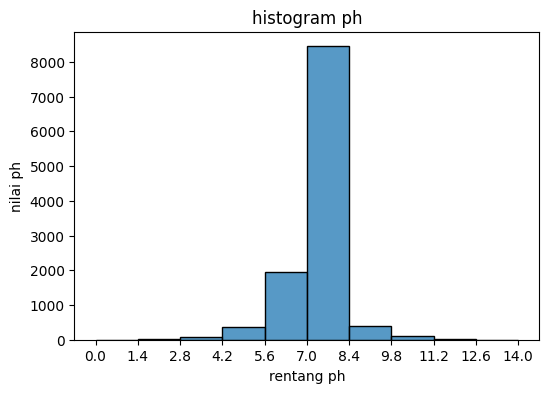

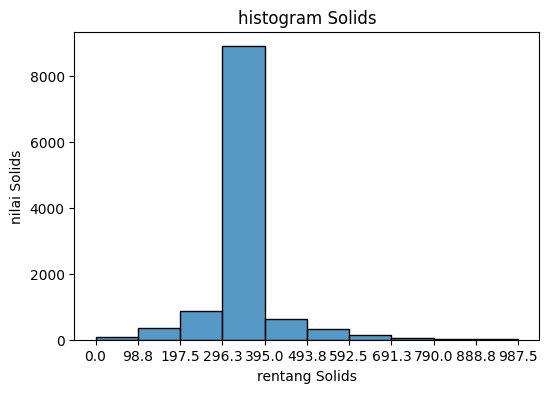

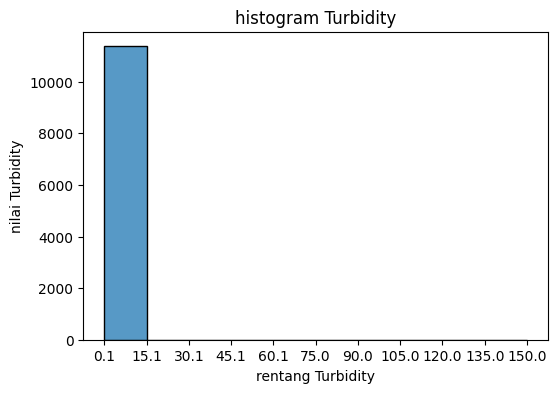

In [59]:
import graph 
columns = df.drop('Potability', axis=1).columns

for col in columns:
    graph.histogram(df[col], f'histogram {col}', f'rentang {col}', f'nilai {col}')
    
    


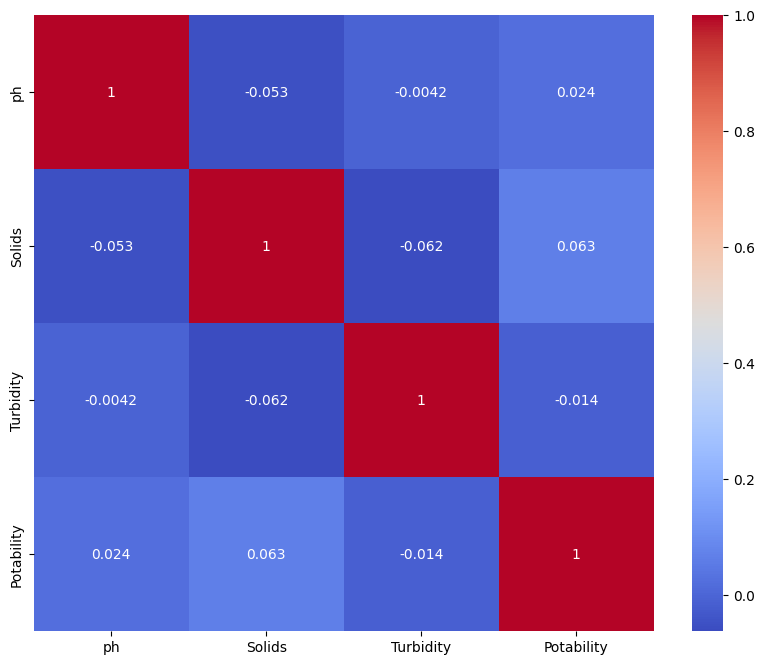

In [60]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

*   korelasi ph dengan potability: -0.02
*   korelasi solids dengan potability: 0.073
*   korelasi turbidity dengan potability: 0.032

Tidak Ada Fitur Dominan: Data ini menunjukkan bahwa tidak ada satu faktor tunggal yang secara langsung menentukan apakah air layak minum atau tidak. Kelayakan air tidak bisa ditebak hanya dengan melihat pH-nya saja atau kekeruhannya saja.

Kesimpulan untuk Pemilihan Model: Rendahnya nilai korelasi ini mengindikasikan bahwa hubungan antara fitur fisikokimia air dan kelayakannya bersifat Non-Linear dan Kompleks. Oleh karena itu, penggunaan algoritma linear (seperti Logistic Regression) kemungkinan besar akan memberikan akurasi yang buruk. Baiknya menggunakan algoritma berbasis Tree dan Ensemble seperti Random Forest atau XGBoost, karena algoritma ini mampu mempelajari pola non-linear yang rumit dari kombinasi banyak fitur sekaligus.

# **Training and Evaluation**

## Split data

In [61]:
x = df[['ph', 'Solids', 'Turbidity']]
print(x.columns)

y = df['Potability'] #cuma y yang hasilnya
print(x.shape, y.shape)

Index(['ph', 'Solids', 'Turbidity'], dtype='object')
(11373, 3) (11373,)


In [62]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(x_train.shape, y_train.shape)

(9098, 3) (9098,)


In [63]:
print(x_test.shape, y_test.shape)

(2275, 3) (2275,)


# Model Selection

In [64]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier , RandomForestClassifier 

In [65]:
models = {
    'Decision_Tree_Class' : DecisionTreeClassifier() , 
    'KNNClassifier' : KNeighborsClassifier(),
    'AdaBoostClassifier' : AdaBoostClassifier(),
    'RandomForestClassifier' : RandomForestClassifier(),
    'XGBClassifier' : XGBClassifier()
}

In [66]:
from sklearn.metrics import accuracy_score , classification_report , confusion_matrix
def evaluate_metrics(true , predict) : 
    accuracy = accuracy_score(true , predict)
    classrep = classification_report(true , predict)
    cf_matrix = confusion_matrix(true , predict)
    return accuracy , classrep , cf_matrix





------- Decision_Tree_Class


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

X TEST PREDS
ACCURACY 0.7283516483516483
 CLASSIFICATION REPORT 
               precision    recall  f1-score   support

           0       0.73      0.75      0.74      1164
           1       0.73      0.70      0.72      1111

    accuracy                           0.73      2275
   macro avg       0.73      0.73      0.73      2275
weighted avg       0.73      0.73      0.73      2275



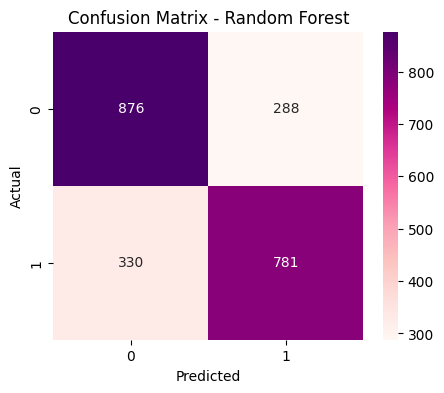





------- KNNClassifier


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

X TEST PREDS
ACCURACY 0.7490109890109891
 CLASSIFICATION REPORT 
               precision    recall  f1-score   support

           0       0.74      0.79      0.76      1164
           1       0.76      0.71      0.73      1111

    accuracy                           0.75      2275
   macro avg       0.75      0.75      0.75      2275
weighted avg       0.75      0.75      0.75      2275



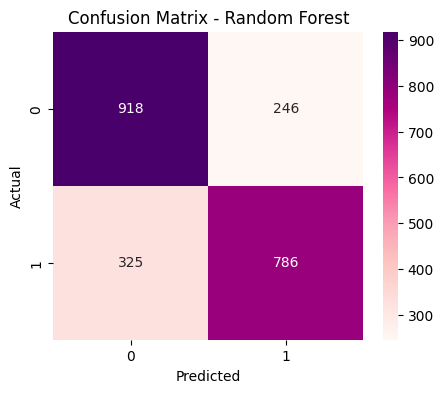





------- AdaBoostClassifier


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

X TEST PREDS
ACCURACY 0.7648351648351648
 CLASSIFICATION REPORT 
               precision    recall  f1-score   support

           0       0.74      0.84      0.79      1164
           1       0.80      0.69      0.74      1111

    accuracy                           0.76      2275
   macro avg       0.77      0.76      0.76      2275
weighted avg       0.77      0.76      0.76      2275



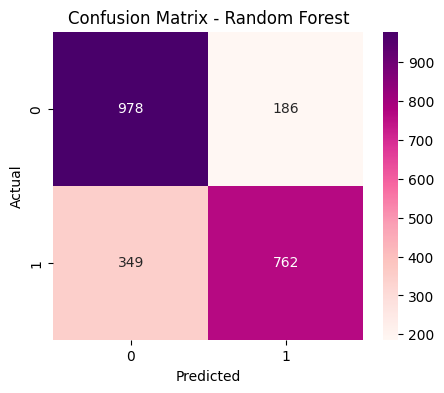





------- RandomForestClassifier


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

X TEST PREDS
ACCURACY 0.7692307692307693
 CLASSIFICATION REPORT 
               precision    recall  f1-score   support

           0       0.74      0.84      0.79      1164
           1       0.80      0.70      0.75      1111

    accuracy                           0.77      2275
   macro avg       0.77      0.77      0.77      2275
weighted avg       0.77      0.77      0.77      2275



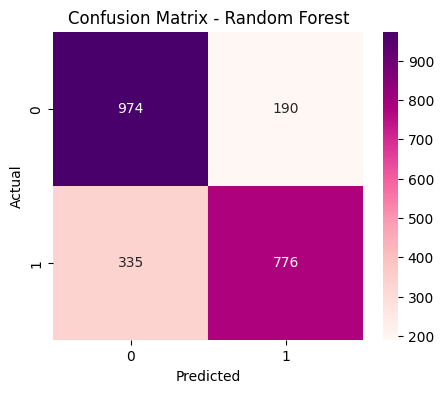





------- XGBClassifier


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

X TEST PREDS
ACCURACY 0.7687912087912088
 CLASSIFICATION REPORT 
               precision    recall  f1-score   support

           0       0.75      0.82      0.78      1164
           1       0.79      0.72      0.75      1111

    accuracy                           0.77      2275
   macro avg       0.77      0.77      0.77      2275
weighted avg       0.77      0.77      0.77      2275



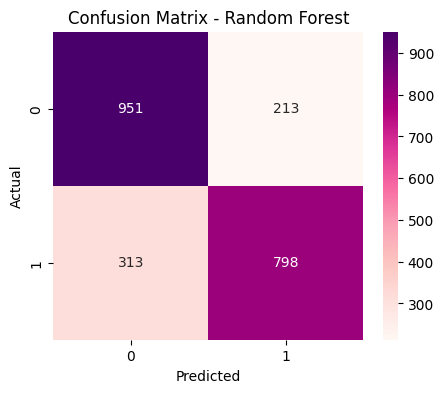

In [67]:
for i in range(len(models)) : 
    model = list(models.values())[i]
    model.fit(x_train , y_train)

    y_pred_test = model.predict(x_test)

    accuracy_test , class_rep_test , cf_matrix_test = evaluate_metrics(y_test , y_pred_test)
    print('\n\n\n')
    print('-------',list(models.keys())[i])
    print('\n')
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n')
    print('X TEST PREDS')
    print(f'ACCURACY {accuracy_test}')
    print(' CLASSIFICATION REPORT \n'  , class_rep_test)
    plt.figure(figsize=(5,4))
    sns.heatmap(cf_matrix_test, annot=True, fmt='d', cmap='RdPu')
    plt.title("Confusion Matrix - Random Forest")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()



In [68]:
# Model Random Forest
model_rf = RandomForestClassifier(n_estimators=500,
    max_depth=8
    )
model_rf.fit(x_train, y_train)

# Model XGBoost 
model_xgb = XGBClassifier(n_estimators=200,
    max_depth=8,
    learning_rate=0.05)
model_xgb.fit(x_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


Akurasi Model: 77.27%

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.84      0.79      1164
           1       0.81      0.70      0.75      1111

    accuracy                           0.77      2275
   macro avg       0.78      0.77      0.77      2275
weighted avg       0.78      0.77      0.77      2275

Accuracy : 0.7727
Precision: 0.8056
Recall   : 0.7048
F1 Score : 0.7518


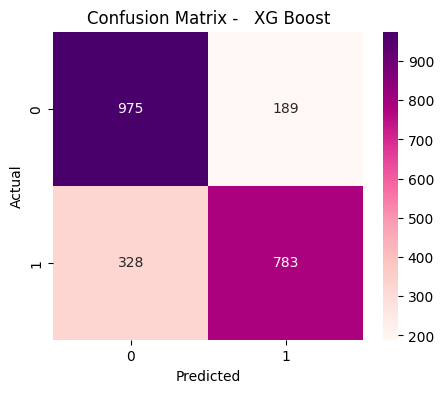

In [74]:
# Prediksi data test
y_pred_xgb = model_xgb.predict(x_test)

# Hitung Akurasi
acc_rf = accuracy_score(y_test, y_pred_xgb)
print(f"Akurasi Model: {acc_rf * 100:.2f}%")

# Tampilkan laporan lengkap
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

accuracy = accuracy_score(y_test, y_pred_xgb)
precision = precision_score(y_test, y_pred_xgb)
recall = recall_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)

print("Accuracy :", round(accuracy, 4))
print("Precision:", round(precision, 4))
print("Recall   :", round(recall, 4))
print("F1 Score :", round(f1, 4))

# Plot confussion matrix
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu')
plt.title("Confusion Matrix -   XG Boost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Akurasi Model: 78.37%

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81      1164
           1       0.85      0.68      0.75      1111

    accuracy                           0.78      2275
   macro avg       0.80      0.78      0.78      2275
weighted avg       0.79      0.78      0.78      2275

Accuracy : 0.7837
Precision: 0.8497
Recall   : 0.6769
F1 Score : 0.7535


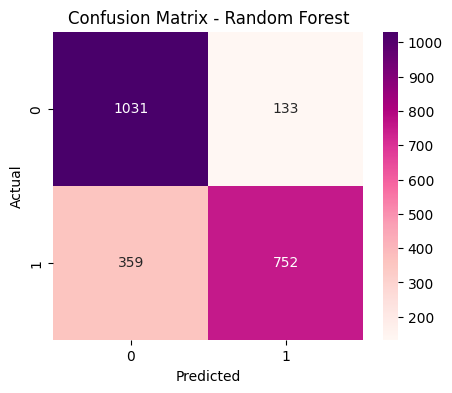

In [75]:
# Prediksi data test
y_pred_rf = model_rf.predict(x_test)

# Hitung Akurasi
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Akurasi Model: {acc_rf * 100:.2f}%")

# Tampilkan laporan lengkap
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)

print("Accuracy :", round(accuracy, 4))
print("Precision:", round(precision, 4))
print("Recall   :", round(recall, 4))
print("F1 Score :", round(f1, 4))

# Plot confussion matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### **Tes rf model with Dummy data**

# **Model**

In [71]:
#Pilih fitur utk regresi
x_final = df.drop('Potability', axis=1)
y_final = df['Potability'] #cuma y yang hasilnya

print(x_final)

# final Train
final_lm = RandomForestClassifier(n_estimators=500,
    max_depth=8
    )# Use the best performing model
final_lm.fit(x_final, y_final) #training the algorithm


             ph      Solids   Turbidity
0      7.160466  365.109446    3.991681
1      7.187738  342.952066    3.957064
2      5.400302  278.493442    4.824786
3      7.078913  347.406221    3.909317
4      7.052283  349.346270    3.989340
...         ...         ...         ...
13362  7.180000  103.300000    0.100000
13364  8.000000  103.300000    0.100000
13365  6.500000  103.300000    0.100000
13366  5.000000  103.300000    0.100000
13368  1.000000  103.300000  150.000000

[11373 rows x 3 columns]


,n_estimators,500
,criterion,'gini'
,max_depth,8
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [72]:
#1.buat dummy data (contoh: air dengan pH normal tapi solid tinggi)
data_baru_final = pd.DataFrame({
    'ph': [7.0, 4.5, 1.0, 3.0, 10.0],                # pH Netral
    'Solids': [200.0, 100.0, 230.0, 323.233,150.22],        # Padatan terlarut (agak tinggi)
    'Turbidity': [0.5, 0.8, 10.0, 2.1, 1.6] 
})

print("Data Baru (Mentah):")
print(data_baru_final)


# 2. prediksi
prediksi = final_lm.predict(data_baru_final)
probabilitas = final_lm.predict_proba(data_baru_final)

# 3. tampilkan Hasil
print("\n--- Hasil Prediksi ---")
for i in range(len(data_baru_final['Turbidity'])):
    print(f'prediksi data ke {i+1}')
    if prediksi[i] == 1:
        print(f"Hasil: 1 (LAYAK MINUM)")
    else:
        print(f"Hasil: 0 (TIDAK LAYAK MINUM)")
    print(f"Confidence (Keyakinan Model): {max(probabilitas[i]) * 100:.2f}%\n")

Data Baru (Mentah):
     ph   Solids  Turbidity
0   7.0  200.000        0.5
1   4.5  100.000        0.8
2   1.0  230.000       10.0
3   3.0  323.233        2.1
4  10.0  150.220        1.6

--- Hasil Prediksi ---
prediksi data ke 1
Hasil: 1 (LAYAK MINUM)
Confidence (Keyakinan Model): 67.44%

prediksi data ke 2
Hasil: 0 (TIDAK LAYAK MINUM)
Confidence (Keyakinan Model): 72.53%

prediksi data ke 3
Hasil: 0 (TIDAK LAYAK MINUM)
Confidence (Keyakinan Model): 59.10%

prediksi data ke 4
Hasil: 0 (TIDAK LAYAK MINUM)
Confidence (Keyakinan Model): 62.20%

prediksi data ke 5
Hasil: 1 (LAYAK MINUM)
Confidence (Keyakinan Model): 52.03%



In [73]:
# Define the filename for the saved model
model_filename = 'model/water_potability_model_v2.pkl'

# Save the trained model to the file
joblib.dump(final_lm, model_filename)

print(f"Trained model saved to {model_filename}")

Trained model saved to model/water_potability_model_v2.pkl
